In [59]:
import sys
import os 
import pandas as pd
sys.path.insert(0, '../src/'); import utils_trees
from importlib import reload
reload(utils_trees)

<module 'utils_trees' from '/Users/spangher/Projects/google-research/schema-generation/notebooks/../src/utils_trees.py'>

In [84]:
model_path = '../experiments/reasoning/qwq-32b/models/chess_agglomerative_clustering_outputs__discretized__labels_descriptions__child-nodes__output-labels-desc/'
os.listdir(model_path)

['hierarchical_tree.gml',
 'optimal_thresholds.csv',
 'labeled_tree_visualization.png',
 'clusters_level_5_14_clusters.csv',
 'inner_node_labels.csv',
 'clusters_level_4_12_clusters.csv',
 'labeled_hierarchical_tree.gml',
 'clusters_level_1_2_clusters.csv',
 'clusters_level_4_10_clusters.csv',
 'clusters_level_2_8_clusters.csv',
 'clusters_level_6_15_clusters.csv',
 'clusters_level_1_3_clusters.csv',
 'clusters_level_3_9_clusters.csv',
 'clusters_level_3_5_clusters.csv',
 'clusters_level_2_4_clusters.csv']

In [85]:
G = utils_trees.load_hierarchical_tree(f'{model_path}/labeled_hierarchical_tree.gml')

In [86]:
utils_trees.get_root(G)

'180'

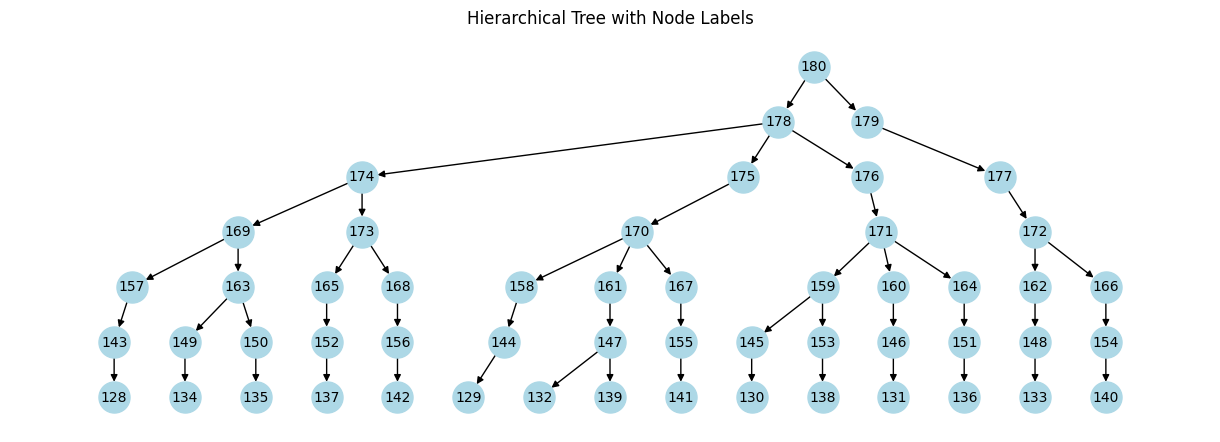

In [87]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx

def draw_tree_with_labels(G):
    """
    Draws the tree with node labels next to them.

    Parameters:
    -----------
    G : networkx.DiGraph
        The tree graph to be drawn.
    """
    pos = graphviz_layout(G, prog='dot')
    labels = {node: G.nodes[node].get('label', str(node)) for node in G.nodes()}
    
    plt.figure(figsize=(12, 4))
    nx.draw(G, pos, with_labels=False, arrows=True, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')
    plt.title("Hierarchical Tree with Node Labels")
    plt.show()

# Call the function to draw the tree
draw_tree_with_labels(G)



In [88]:

def check_sibling_exclusivity(G):
    """
    Checks if nodes on the same level in the tree have mutually exclusive sets of datapoint indices.

    Parameters:
    -----------
    G : networkx.DiGraph
        The tree graph to be checked.

    Returns:
    --------
    exclusivity : bool
        True if all nodes on the same level have mutually exclusive datapoint indices, False otherwise.
    """
    # Get all nodes with their levels
    levels = {}
    for node in nx.topological_sort(G):
        level = 0 if G.in_degree(node) == 0 else max(levels[pred] + 1 for pred in G.predecessors(node))
        levels[node] = level

    # Group nodes by their levels
    level_nodes = {}
    for node, level in levels.items():
        if level not in level_nodes:
            level_nodes[level] = []
        level_nodes[level].append(node)

    # Check exclusivity for each level
    for nodes in level_nodes.values():
        sibling_indices = [set(G.nodes[node].get('datapoint_indices', [])) for node in nodes]
        for i in range(len(sibling_indices)):
            for j in range(i + 1, len(sibling_indices)):
                if sibling_indices[i].intersection(sibling_indices[j]):
                    return False
    return True, level_nodes
# Check if sibling nodes have mutually exclusive datapoint indices
exclusivity, level_nodes = check_sibling_exclusivity(G)
print("Sibling nodes have mutually exclusive datapoint indices:", exclusivity)


Sibling nodes have mutually exclusive datapoint indices: True


In [89]:
inner_nodes_labels = pd.read_csv(f'{model_path}/inner_node_labels.csv')

In [90]:
inner_nodes_labels.head(2)

,node_id,label,description
0,140,Perspective Alignment,The reasoning involves aligning chessboard coo...
1,133,Knight Movement,Focuses on calculating possible knight moves f...


In [91]:
inner_nodes_labels['node_id'] = inner_nodes_labels['node_id'].astype(str)

In [92]:
label_dict = inner_nodes_labels.set_index('node_id')['label'].apply(lambda x: x.replace(' ', '\n')).to_dict()
nx.set_node_attributes(G, label_dict, 'label')


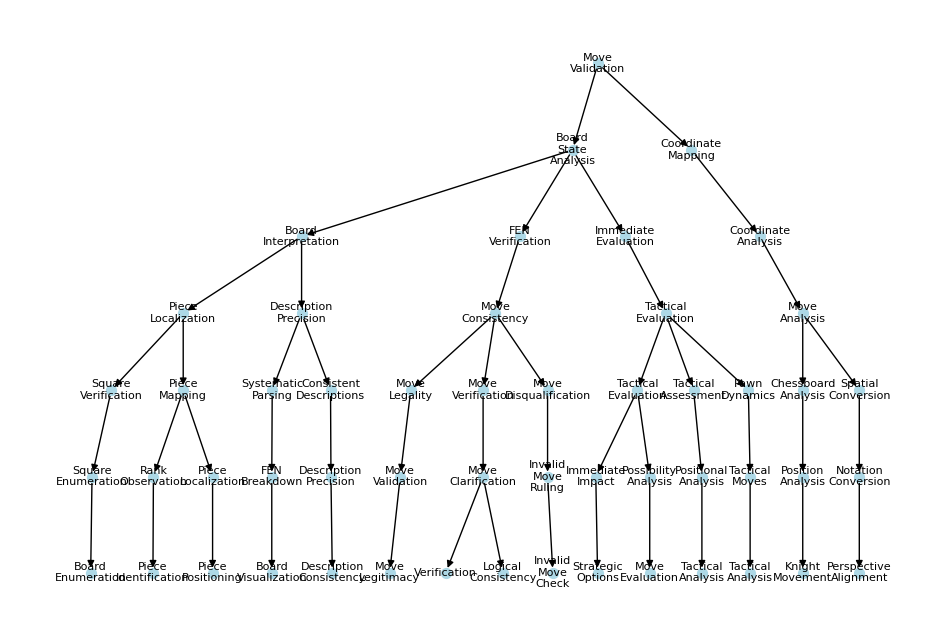

In [93]:
utils_trees.plot_graph(
    G, 
    with_labels=True, 
    with_node_id=False,
    with_sizes=False, 
    label_name='label', 
    font_size=8, 
    size_name='subtree_size', 
    adjust_text_on_labels=False, 
    # adjust_text_force_static=(0.1, 0.2)
)

In [94]:
level_node_df = (
    pd.Series(level_nodes).explode().to_frame('node_id')
    .reset_index().rename(columns={'index': 'level'})
)

In [166]:
inner_nodes_labels.merge(level_node_df, on='node_id').to_csv(f'{model_path}/labels_and_descriptions.csv', index=False)

# Is there a difference in reasoning steps between correct and incorrect answers? 

In [191]:
cluster_assignments = pd.read_csv(f'{model_path}/../../clusters/nodes_with_preliminary_clusters.csv.gz')

In [205]:
ls '../experiments/reasoning/qwq-32b/make_hierarchy/'

chunk_sample_exploded.csv.gz   qwen-half-downsampled.csv.gz
qwen-downsampled.csv.gz        qwq-32b-rollouts-labeled.json


In [221]:
chess_original_input_df = (
    pd.read_csv('../experiments/reasoning/qwq-32b/make_hierarchy/qwen-half-downsampled.csv.gz', compression='gzip', index_col=0)
    .loc[lambda df: df['category'] == 'chess_puzzle']
)

In [213]:
labeled_data = cluster_assignments.loc[lambda df: df['index'].str.split('__').str.get(0) == 'chess_puzzle']

In [293]:
joined_labeled_data_and_scores = (
    labeled_data
        .assign(step_index=lambda df: df['index'].str.split('reasoning-step-').str.get(1).astype(int))
        .assign(rollout_index=lambda df: df['index'].str.split('__reasoning-step').str.get(0))
        .sort_values(['rollout_index', 'step_index'])
        .drop_duplicates(subset=['rollout_index', 'step_index'])
        .groupby('rollout_index')
        .agg(
            reasoning_steps=('step_index', list),
            cluster_labels = ('cluster', list)
        )        
        .reset_index()
        .merge(chess_original_input_df, left_on='rollout_index', right_on='index')
        .drop(columns=['index', 'uid', 'rollouts', 'model_path', 'category'])
)

In [285]:
inner_node_to_leaf_node_ids = nx.get_node_attributes(G, 'leaf_node_ids')
leaf_node_to_inner_node = (
    pd.Series(inner_node_to_leaf_node_ids)
    .explode()
    .to_frame('leaf_node_id')
    .reset_index()
    .rename(columns={'index': 'inner_node_id'})
    .astype(int)
    .merge(level_node_df.astype(int), left_on='inner_node_id', right_on='node_id', how='left')
    .drop(columns=['node_id'])
)
# leaf_node_to_inner_node = leaf_node_to_inner_node.set_index('leaf_node_id')['inner_node_id'].to_dict()

In [383]:
import numpy as np 
level_n_leaf_node_to_inner_node_dict = (
    leaf_node_to_inner_node
        .loc[lambda df: df['level'] == 3]
        .set_index('leaf_node_id')['inner_node_id']
        .to_dict()
)
exp_joined_labeled_data_and_scores = (
    joined_labeled_data_and_scores
        .assign(num_reasoning_steps=lambda df: df['reasoning_steps'].str.len())
        .explode(['reasoning_steps', 'cluster_labels'])
        .assign(inner_node_id=lambda df: df['cluster_labels'].map(level_n_leaf_node_to_inner_node_dict))
        .assign(reasoning_step_perc=lambda df: df['reasoning_steps'] / df['num_reasoning_steps'])
        .assign(reasoning_step_perc_bin=lambda df: pd.cut(df['reasoning_step_perc'], np.arange(0, 1.05, .05)).apply(lambda x: x.right).astype(float).fillna(0))
        .merge(inner_nodes_labels.assign(node_id=lambda df: df['node_id'].astype(int)), left_on='inner_node_id', right_on='node_id', how='left')
        .drop(columns=['node_id'])
)

In [384]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 

pos_agg_df = (
    exp_joined_labeled_data_and_scores
         .loc[lambda df: df['scores'] == 1]
         .assign(c=1)
         .pivot_table(columns='reasoning_step_perc_bin', index='label', values='c', aggfunc='sum')
         .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
         .sort_values(.95)
         .fillna(0)
         # .sort_values(.05, ascending=False)
         
)

neg_agg_df = (
    exp_joined_labeled_data_and_scores
         .loc[lambda df: df['scores'] == 0]
         .assign(c=1)
         .pivot_table(columns='reasoning_step_perc_bin', index='label', values='c', aggfunc='sum')
         .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
         .loc[pos_agg_df.index]
         .fillna(0)
         # .sort_values(.05, ascending=False)
         
)

In [385]:
vmax = pd.concat([pos_agg_df.max(), neg_agg_df.max()]).max()
vmin = pd.concat([pos_agg_df.min(), neg_agg_df.min()]).min()

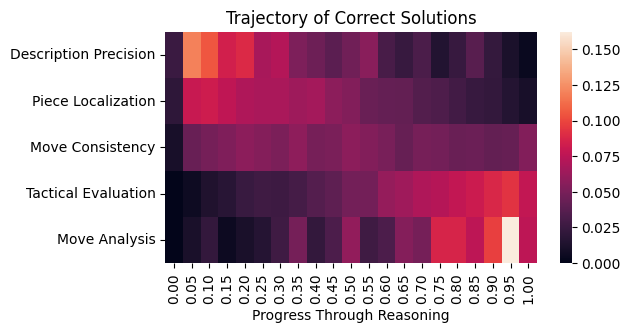

In [402]:
from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(1, 1, figsize=(6, 3))
pos_agg_df.pipe(lambda df: sns.heatmap(df, vmax=vmax, vmin=vmin))#, vmax=.102))
ax.set_title('Trajectory of Correct Solutions')
ax.set_ylabel('')
ax.set_xlabel('Progress Through Reasoning')
ax.set_xticks(np.arange(len(neg_agg_df.columns)) + .5, list(map(lambda x: f'{x:.2f}', neg_agg_df.columns)));

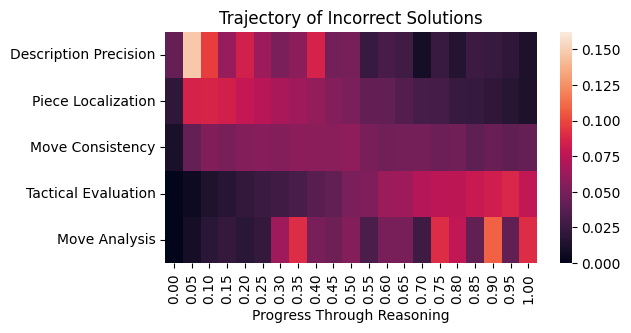

In [400]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))
neg_agg_df.pipe(lambda df: sns.heatmap(df, vmax=vmax, vmin=vmin,fmt='.2f'))#, vmax=.102))
ax.set_title('Trajectory of Incorrect Solutions')
ax.set_ylabel('')
ax.set_xlabel('Progress Through Reasoning')
ax.set_xticks(np.arange(len(neg_agg_df.columns)) + .5, list(map(lambda x: f'{x:.2f}', neg_agg_df.columns))); 

# look at example reasoning steps -- useful for ICL examples

In [179]:
pd.read_csv(f'{model_path}/labeled_chunks__level-2.csv', index_col=0)

,index,chunks,chunk_idx,labels
Unnamed: 0,,,,
0,chess_puzzle__145022__1,"Okay, let me try to figure out this chess puzz...",0,Immediate Evaluation
1,chess_puzzle__145022__1,"First, I should parse the FEN to visualize the...",1,Board Interpretation
2,chess_puzzle__145022__1,"1st rank (Black's 1st, White's 8th): 3r2k1. So...",2,FEN Verification
3,chess_puzzle__145022__1,"Wait, but that would make the king on g8 and r...",3,Coordinate Analysis
4,chess_puzzle__145022__1,"Hmm, but the letters are case-sensitive. Lower...",4,Board Interpretation
...,...,...,...,...
324,chess_puzzle__37370__1,"Hmm, this is really confusing. Maybe I should ...",24,Immediate Evaluation
325,chess_puzzle__37370__1,"Alternatively, maybe the move was a different ...",25,Immediate Evaluation
326,chess_puzzle__37370__1,"Alternatively, perhaps the move is a knight fr...",26,Immediate Evaluation


In [ ]:
## the rest is irrelevant...

# Make new chunks

In [104]:
ls ../experiments/reasoning/qwq-32b/make_hierarchy/

qwen-downsampled.csv.gz        qwq-32b-rollouts-labeled.json
qwen-half-downsampled.csv.gz


In [105]:
import pandas as pd 
qwen_df = pd.read_csv('../experiments/reasoning/qwq-32b/make_hierarchy/qwen-downsampled.csv.gz')

In [117]:
import warnings

# Silence specific warnings
warnings.filterwarnings(
    "ignore", 
    category=SyntaxWarning
)

In [183]:
CHUNKING_PROMPT = """
You are a helpful notetaker. I will give you a math problem and my reasoning thread.

Your task is to chunk the reasoning thread so that each corresponds to ONE discrete reasoning step. A single step should be a COMPLETE thought or idea.
If I apply the same operation multiple times in my reasoning, group these lines into a single step.
Copy each reasoning chunk exactly. Be 100% sure that all text between the <reasoning_thread> tags gets copied into ONE step. Do NOT skip any text.

Here's a very short example (the ones you see will be longer):
<example>
    input:
    <reasoning_thread>
    First, I remember that inequalities often involve techniques like AM-GM, Cauchy-Schwarz, or other classical inequalities. 
    Maybe I can start by looking at each term on the left side and see if I can manipulate them to relate to the right side. 
    The left side has three terms: \(\frac{{1}}{{a(1+b)}}\), \(\frac{{1}}{{b(1+c)}}\), and \(\frac{{1}}{{c(1+a)}}\). 
    Each denominator has a variable multiplied by \(1\) plus another variable. The right side is \(\frac{{3}}{{1+abc}}\), which is symmetric in \(a, b, c\). 
    But how do I get from here to the general proof?
    Let me consider using the AM-GM inequality. AM-GM states that for non-negative real numbers, the arithmetic mean is at least the geometric mean. Maybe I can apply AM-GM to the denominators or somehow to the entire terms.
    </reasoning_thread>
    
    output:
    {{
        'chunks': [
            "First, I remember that inequalities often involve techniques like AM-GM, Cauchy-Schwarz, or other classical inequalities. Maybe I can start by looking at each term on the left side and see if I can manipulate them to relate to the right side. The left side has three terms: \(\frac{{1}}{{a(1+b)}}\), \(\frac{{1}}{{b(1+c)}}\), and \(\frac{{1}}{{c(1+a)}}\). Each denominator has a variable multiplied by \(1\) plus another variable. The right side is \(\frac{{3}}{{1+abc}}\), which is symmetric in \(a, b, c\).",
            "But how do I get from here to the general proof? Let me consider using the AM-GM inequality. AM-GM states that for non-negative real numbers, the arithmetic mean is at least the geometric mean. Maybe I can apply AM-GM to the denominators or somehow to the entire terms. Alternatively, maybe Cauchy-Schwarz can be applied here. But I'm not sure if that's directly applicable.",
        ]
    }}
</example>

Notice how each step is a complete thought or operation. Now it's your turn. Remember to follow the example format exactly (except with more steps). 
Again, do not skip any text or add any text. Only chunk the text between the <reasoning_thread> tags into complete reasoning steps.

input:
<reasoning_thread>
{reasoning_thread}
</reasoning_thread>

output:
"""

In [125]:
from pydantic import BaseModel
from typing import List

class ChunkOutput(BaseModel):
    chunks: List[str]

In [126]:
from utils_openai_client import prompt_openai_model

In [137]:
chess_rollouts = qwen_df.loc[lambda df: df['index'].str.split('__').str.get(0) == 'chess_puzzle']

In [180]:
from tqdm.auto import tqdm
all_chunks = []
chess_rollouts['rollouts'].str.split().str.len().median()

7711.0

In [ ]:
short_chunks = chess_rollouts.loc[lambda df: df['rollouts'].str.split().str.len() < 6000].sample(50)
for _, row in tqdm(short_chunks[['index', 'rollouts']].iterrows(), total=len(short_chunks)):
    rollout = row['rollouts']
    prompt = CHUNKING_PROMPT.format(reasoning_thread=rollout)
    chunks = prompt_openai_model(prompt, response_format=ChunkOutput)
    all_chunks.append({
        'index': row['index'],
        'chunks': chunks.chunks
    })

In [153]:
all_chunks = pd.DataFrame(all_chunks)


In [162]:
chunk_sample_exploded =(all_chunks
 .explode('chunks').reset_index(drop=True).reset_index()
 .assign(chunk_idx=lambda df: df.groupby('index')['level_0'].rank(method='dense', ascending=True).astype(int) - 1)
 .drop(columns=['level_0'])
)

In [164]:
chunk_sample_exploded.to_csv('../experiments/reasoning/qwq-32b/make_hierarchy/chunk_sample_exploded.csv.gz', compression='gzip')